In [220]:
import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import os
import json
from pandas import DataFrame, Series
from collections import defaultdict
from math import log
%matplotlib inline

### 第一赛季
1月27日（周五）早10点 － 1月30日（周一）早10点

SeasonId:5885e0c6684a332c58913c05

### 第二赛季
1月30日（周一）早10点 － 2月3日（周五）早10点

SeasonId:5885e1000d2b3a7658b3e4b4

In [74]:
SeasonLog = pd.read_json("/Users/kuangzheng/Desktop/GameAI/Data/log_data/SpringCup.json", lines=True)
SeasonLog['time'] = SeasonLog['time'].str.rsplit(' ',expand=True)[0]
SeasonLog = SeasonLog[SeasonLog['gameStatus'] == 1]

## 目前只有两个赛季数据，写初步逻辑时暂且用第一个season做train，第二个作test好了

In [92]:
seasonLog_1 = SeasonLog[SeasonLog.seasonId == '5885e0c6684a332c58913c05']
seasonLog_2 = SeasonLog[SeasonLog.seasonId == '5885e1000d2b3a7658b3e4b4']

# 1st Step

### 玩家game表现评价模型
### 目的输出：玩家user在不同Season，Session，Game的得分

In [122]:
seasonLog_1.dtypes

gameId            int64
gameMultiple      int64
gameResult      float64
gameStatus        int64
role              int64
seasonId         object
sessionId         int64
time             object
user             object
dtype: object

In [221]:
seasonLog_1.head()

,gameId,gameMultiple,gameResult,gameStatus,role,seasonId,sessionId,time,user
39986,0,3,-12.0,1,1,5885e0c6684a332c58913c05,48,2017/1/27,5847f6c3c6c490a90ad826d4
39987,1,3,-6.0,1,1,5885e0c6684a332c58913c05,48,2017/1/27,5847f6c3c6c490a90ad826d4
39988,0,3,-6.0,1,2,5885e0c6684a332c58913c05,13,2017/1/27,58418a679782eed425239b6a
39989,2,3,12.0,1,1,5885e0c6684a332c58913c05,48,2017/1/27,5847f6c3c6c490a90ad826d4
39990,1,3,-6.0,1,1,5885e0c6684a332c58913c05,13,2017/1/27,58418a679782eed425239b6a


# 满分是多少？Max和Min本身差多少

In [226]:
#先生成每一个game的distibution
def get_score_distribution(sl):
    
    grouped = sl.groupby(['seasonId', 'sessionId', 'gameId', 'gameResult'])
    score_d = grouped.user.count().rename('userNum')
    score_d = score_d.unstack().fillna(0)
    d = dict()
    
    for _, l in score_d.iterrows():
        d[_] = l.rename('userNum')
    score_d = d
    return score_d

#在生成每一个玩家在每一个game上目前的一个得分情况
def get_player_game_score(seasonId, sessionId, gameId, score_d, game_result):

    game_score_d = score_d[(seasonId, sessionId, gameId)]
    num = game_score_d.sum() - 1
    val_num_1 = game_score_d[game_score_d.index < game_result].sum()
    val_num_2 = (game_score_d[game_score_d.index == game_result].sum() - 1) / 2
    
    if num == 0:
        return 50
    else:
        score = (val_num_1 + val_num_2) / num
        score *= 100
        return score

#生成每位玩家在每局game上的评分，需要保存下来    
def get_all_player_game_scores(sl):

    score_d = get_score_distribution(sl)
    p_scores = {}
    
    for _, l in sl.iterrows():
        info = tuple([l.user, l.seasonId, l.sessionId, l.gameId])
        try:
            score = get_player_game_score(*info[1:], score_d, l.gameResult)
            p_scores[info] = score
        except:
            pass
    return p_scores

下面将玩家得分暂时存储起来

In [228]:
p_scores_path = '/Users/kuangzheng/Programming/GameAI/Data/log_data/tmp/player_scores.season1'
p_scores = get_all_player_game_scores(seasonLog_1)
p_scores = Series(p_scores)
p_scores.name = 'gameScore'
p_scores.index.names = ['user', 'seasonId', 'sessionId', 'gameId']
p_scores.to_frame().to_csv(p_scores_path, float_format = '%.2f')

In [229]:
p_scores.to_frame().head()

gameScore
user                     seasonId                 sessionId gameId           
582ed893b40ccb6f0a70cac3 5885e0c6684a332c58913c05 2         0           36.25
                                                            1           31.82
                                                            2           54.55
                                                            3           61.11
                                                            4           64.29

为了查询方便进一步以字典形式处理p_scores

In [497]:
p_scores_dict = {}
normalization=False#不改变分布但是强调了分数的重要性
for ind in p_scores.index:
    s = p_scores.loc[ind[:3]]
    if normalization == True:
        s = (s - s.min())/(s.max() - s.min()) * 100
    if ind[:3] not in p_scores_dict:
        p_scores_dict[ind[:3]] = s

# 2nd Step
### game区分度模型
### 目的输出：Season，Session，Game的区分度

In [197]:
def compute_disc(freq):
    #在这里不光可以进行基础的shannon计算，也可以进一步的考察难易性等
    if freq.sum() != 1:
        freq /= freq.sum()
    if isinstance(freq, (np.ndarray, Series)):
        disc = 0
        for p in freq:
            if p != 0:
                disc += -p * np.log2(p)
        return disc
    else:
        raise TypeError('wrong type')

def get_game_disc(seasonId, sessionId, gameId, score_d):
    #直接计算game的区分度
    game_score_d = score_d[(seasonId, sessionId, gameId)].copy()
    game_score_d /= game_score_d.sum()
    disc = get_disc(game_score_d)
    return disc

def all_games_discs(sl):
    
    score_d = get_score_distribution(sl)
    g_discs = {}
    
    for _, l in sl.iterrows():
        info = tuple([l.seasonId, l.sessionId, l.gameId])
        try:
            disc = get_game_disc(*info, score_d)
            g_discs[info] = disc
        except:
            pass
    return g_discs

### game一致性模型
### 目的输出：Season，Session内不同game之间的关联性

In [546]:
def get_session_game_score_dict(sl):
    gameResult = sl.set_index(['seasonId', 'sessionId','user','gameId']).gameResult
    session_game_score = gameResult.unstack()
    session_game_score_dict = {}
    for ind in session_game_score.index:
        scores = session_game_score.loc[ind[:2]]
        if ind[:2] not in session_game_score_dict:
            session_game_score_dict[ind[:2]] = scores
    return session_game_score_dict

def get_session_game_kendall_dict(session_game_score_dict):
    #计算每个session中的每个game相互之间的kendall系数
    session_game_kendall_dict = {}
    for _, scores in session_game_score_dict.items():
        cons = scores.corr(method='kendall')
        cons = cons.mean()
        session_game_kendall_dict[_] = cons
    return session_game_kendall_dict

def get_kendall_filter_game_dict(session_game_kendall_dict):
    #根据前面的数据进行game层面的过滤
    kendall_filter_game_dict = {}
    for _, v in session_game_kendall_dict.items:
        kendall_filter_game_dict[_] = 
        
        

In [547]:
d = get_session_game_score_dict(test_sl)

In [557]:
d[('5885e1000d2b3a7658b3e4b4',0)].corr(method='kendall').mean().sort_values()

gameId
4    0.13
2    0.26
3    0.29
5    0.30
1    0.34
0    0.36
dtype: float64

#### 将不同game区分度存起来
#### 并且做一下区分度的分布，可以看出差异对于玩家分布的差异较大

In [207]:
g_discs_path = '/Users/kuangzheng/Programming/GameAI/Data/log_data/tmp/game_discrimination.season1'
g_discs = all_games_discs(seasonLog_1)
g_discs = Series(g_discs)
g_discs.name = 'gameDiscrimination'
g_discs.index.names = ['seasonId', 'sessionId', 'gameId']
g_discs.to_frame().to_csv(g_discs_path, float_format = '%.2f')

In [223]:
g_discs.to_frame().head()

gameDiscrimination
seasonId                 sessionId gameId                    
5885e0c6684a332c58913c05 0         0                     2.32
                                   1                     0.61
                                   2                     1.03
                                   3                     1.57
                                   4                     1.88

均值为:1.24
标准偏差为:0.56


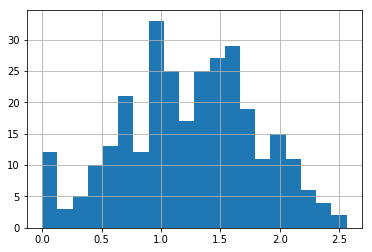

In [224]:
g_discs.hist(bins=20)
print('均值为:{:.3}'.format(g_discs.mean()))
print('标准偏差为:{:.2}'.format(g_discs.std()))

为了查询方便将g_discs存储为dict格式

In [238]:
g_discs_dict = {}
for ind in g_discs.index:
    g_discs_dict[ind[:3]] = g_discs.loc[ind[:3]]

# 3rd Step
### 玩家session表现评价模型
### 目的输出：玩家player在不同Season，Session的上的得分


In [434]:
def get_player_session_score(user, seasonId, sessionId, p_scores_dict, g_discs_dict, disc=True):
    #计算某一玩家在某一session的得分情况
    user_games = p_scores_dict[(user, seasonId, sessionId)]
    if len(user_games) < 6:
        return 1
    else:
        session_score = 0
        weight = 0
        for g, s in user_games.iteritems():
            if disc == True:
                g_weight = g_discs_dict[(seasonId, sessionId, g)]
            else:
                g_weight = 1
            session_score += s * g_weight
            weight += g_weight
        session_score /= weight
        return session_score

def get_all_player_session_scores(sl, p_scores_dict, g_discs_dict, disc=True):
    #将每位玩家完成的session给出评分
    user_sessions = sl[['user', 'seasonId', 'sessionId']].drop_duplicates()
    p_session_scores = {}
    for _, i in user_sessions.iterrows():
        us = tuple(i)
        us_score = get_player_session_score(*us, p_scores_dict, g_discs_dict, disc)
        p_session_scores[us] = us_score
    return p_session_scores

# 4th Step
### 直接取平均分作为season得分可以

In [439]:
def get_player_season_scores(sl, p_scores_dict, g_discs_dict, disc):
    p_session_scores = get_all_player_session_scores(sl, p_scores_dict, g_discs_dict, disc)
    p_session_scores = Series(p_session_scores, name='p_session_scores')
    p_session_scores.index.name = 'user'
    p_session_scores = p_session_scores[p_session_scores != 1]
    p_season_scores = p_session_scores.mean(level=0)
    return p_season_scores

# 5rd Test
### 对模型进行进一步的评测，测试排名算法的准确性，比较实际得分

In [490]:
def get_game_player_result_dict(sl):
    #生成每一game_player_result的查询表,格式'seasonId', 'sessionId', 'gameId', 'user'
    sl_dict = sl.set_index(['seasonId', 'sessionId', 'gameId', 'user'])
    result = sl_dict.gameResult
    result_dict = result.to_dict()
    return result_dict

def get_game_player_dict(sl):
    #生成每局game_player查询表,格式'seasonId', 'sessionId','gameId'
    sl_dict = sl.set_index(['seasonId', 'sessionId', 'gameId'])
    users = sl_dict.user
    user_dict = {}
    for ind in users.index:
        user_dict[ind] = list(users.loc[ind])
    return user_dict

def get_pair_player_compare(seasonId, sessionId, gameId, user_1, user_2, test_result_dict, train_p_season_scores):
    #比较查询，返回两个值，是否合法，是否存在
    #本赛季result_dict
    #之前的p_season_scores
    game_user_1 = (seasonId, sessionId, gameId, user_1)
    game_user_2 = (seasonId, sessionId, gameId, user_2)
    try:
        
        r = 0
        score_1 = train_p_season_scores[user_1]
        score_2 = train_p_season_scores[user_2]
        score_diff = score_1 - score_2
        result_1 = test_result_dict[game_user_1]
        result_2 = test_result_dict[game_user_2]
        result_diff = result_1 - result_2
        
        if score_diff * result_diff > 0:
            return 1, 1
        elif result_diff == 0:
            return 1, 0.5
        else:
            return 1, 0
        
    except KeyError:
        return 0, 0

def get_test_data_result(test_sl, train_p_season_scores):
    ##season log
    result_dict = get_game_player_result_dict(test_sl)
    user_dict = get_game_player_dict(test_sl)
    games = test_sl[['seasonId', 'sessionId', 'gameId']].drop_duplicates()
    total_val, total_hit = 0, 0
    for g in games.itertuples(index=False, name=None):
        users = user_dict[g]
        
        for i in range(len(users)):
            for j in range(i+1, len(users)):
                val, hit = get_pair_player_compare(*g, users[i], users[j], result_dict, train_p_season_scores)
                total_val += val
                total_hit += hit

    return total_val, total_hit

# 测试环节

In [478]:
test_sl = seasonLog_2

In [498]:
ps = get_player_season_scores(sl, p_scores_dict, g_discs_dict, True)

In [503]:
get_test_data_result(seasonLog_2, ps)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  


(183731, 97196.5)

最初版新方法：  train: (194399, 107533.5) test:(183731, 98529.5)

原始方法准确率：train: (194399, 107589.5) test:(183731, 98528.5)

对每局game玩家修改分数权重后:train:(194399, 105632.5) test:(183731, 97196.5)